<font size="+3"><strong>Machine Learning: Classification</strong></font>

In [205]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder, OrdinalEncoder
from IPython.display import YouTubeVideo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.simplefilter(action="ignore", category=FutureWarning)

# Data Preprocessing

For the examples here, we'll look at buildings in the Ramechhap district of Nepal. (In our SQLite database, Ramechhap has the `district_id` of `1`.) Run the wrangle function below to connect to the SQLite database load the data into the DataFrame `df`.

In [206]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 1
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1]
    df["damage_grade"] = pd.to_numeric(df["damage_grade"], errors="coerce")
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    drop_cols.append("building_id")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    
    return df

In [207]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
56,40,322,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
63,1,437,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Timber-Planck,Not attached,Rectangular,"Stone, mud mortar",0
97,22,420,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
99,50,242,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
115,12,308,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Timber-Planck,Not attached,Rectangular,"Stone, mud mortar",0


# Data Segregation

## Training Sets

### Randomized Train-Test split

**Splitting a dataset** into different sets is an important part of the model development process. The initial dataset is typically split into **two** (**training** and **testing**) or **three** (**training**, **validation**, and **testing**) datasets. This helps ensure that the model can generalize. Usually, more data is used for training than for validation or testing. If splitting into two datasets, a good rule of thumb is to split your data randomly into a ratio of **80:20** training:testing. If splitting into three datasets, splitting the data into a ratio of **70:20:10** (training:validation:testing) is commonly used. 

Validation datasets are usually used to tune model hyperparameters. A hyperparameter is a model setting that can't be learned during model training and must be explicitly set. In contrast, a model parameter can be learned. An example of a hyperparameter is the depth of a decision tree . An example of a model parameter includes a coefficient of a variable from linear regression.

In order to split our data, we'll be using the `train_test_split` function from scikit-learn. We'll begin by splitting our data into a training and testing set. Next, we'll apply the `train_test_split` function to our testing set to generate our validation dataset and new testing dataset. 

We will create a feature matrix X and target vector y. The target is "severe_damage".

In [208]:
df.columns

Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'superstructure', 'severe_damage'],
      dtype='object')

In [209]:
target = "severe_damage"

Drop the target from the DataFrame and save the results into a X. Save the target column into y. 

In [210]:
X = df.drop(columns=[target])
y = df[target]

Finally, we will split our dataset into a training and test set using the `train_test_split` function from `scikit-learn`. 

In [211]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Validation Set

<font size="+1">Practice: Perform a randomized split using scikit-learn</font>

Try it yourself! Use `train_test_split` to divide the training data (X_train and y_train) into training and validation sets using the same randomized train-test split function used previously. The validation data will be 20% of the previously constructed training data. Don't forget to set a random_state.

In [212]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Key Concepts

## Majority and Minority Classes

The majority class refers to whatever category in a binary target occurs most frequently, and the minority class refers to whatever category in a binary target occurs less frequently. Let's use the `value_counts` method to plot the relative frequency of the two plots with a bar chart.  

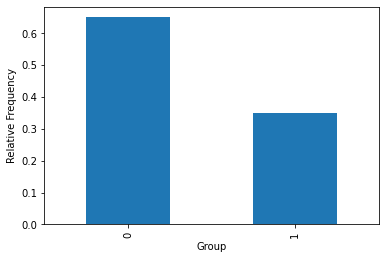

In [213]:
y_train.value_counts(normalize=True).plot(
    kind="bar", xlabel="Group", ylabel="Relative Frequency"
);

Since the category 1 (`severe_damage` = True) occurs most frequently, this is the majority class. 

## Positive and Negative Classes

**Positive class** and **negative class** are the two possible labels for binary classification problems. For example, if we are classifying whether an email is spam or not, we can designate "spam" as the positive class and "not spam" as the negative class. For the example in the project, we have "bankrupt" as the positive class and "not bankrupt" as the negative class. Conventionally, we use `0` or `False` to represent negative class, and `1` or `True` to represent positive class.

# Classification with Logistic Regression

## Logistic Regression
The logistic regression model is the classifier version of linear regression. It will predict probability values that can be used to assign class labels. The model works by taking the output of a linear regression model and feeding it into a sigmoid or logistic function. 

Why transform a linear model this way? Linear regression models are great for **regression** problems because they can give you predictions that range from negative infinity to positive infinity. However, the sigmoid function bounds predictions between 0 and 1, which we then treat as a probability. This allows us to use the model for **classification** problems. 

An example of the sigmoid function is shown below.

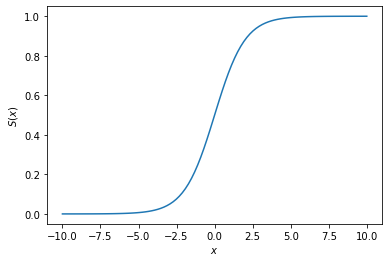

In [214]:
x = np.linspace(-10, 10, 100)
s = 1 / (1 + np.exp(-x))

plt.plot(x, s)
plt.xlabel("$x$")
plt.ylabel("$S(x)$");

The following video summarizes the math behind logistic regression:

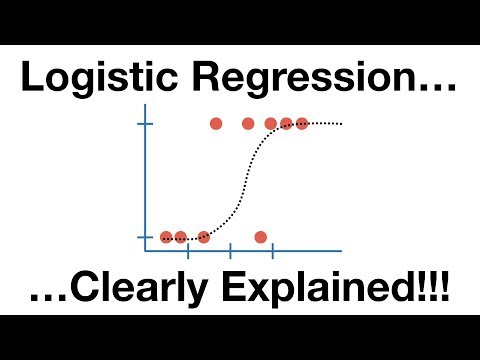

In [215]:
YouTubeVideo("yIYKR4sgzI8")

You can add the logistic regression as a named step in a model pipeline like below:

In [216]:
lr_model = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    LogisticRegression(max_iter=1000)
)
lr_model.fit(X_train, y_train);

## High-cardinality Features

Cardinality refers to the number of unique values in a categorical variable. High cardinality means the categorical features have a large number of unique values. These features often don't work well with either one hot encoding or ordinal encoding. There is no exact number of unique values that makes a feature high-cardinality, but if the value of the categorical feature is unique for almost all observations, it can usually be dropped. You can see the number of unique values in a variable by using the `value_counts` method. For example, to check the number of unique values in the `roof_type` column:

In [217]:
df["roof_type"].value_counts()

Bamboo/Timber-Light roof    25276
Bamboo/Timber-Heavy roof     9822
RCC/RB/RBC                    187
Name: roof_type, dtype: int64

There are only three unique values, so we will leave the column in the DataFrame. 

<font size="+1">Practice</font>

Try it yourself! Use `value_counts` to check the number of unique values in the `building_id` column. Remove the column in the wrangle function if it has a large number of unique values. 

In [218]:
# REMOVE{
# X_train["building_id"].value_counts()
# REMOVE }

# Classification with Tree-based Models

## Decision Trees

Decision trees are a general class of machine learning models that are used for both classification and regression. The model resemble a tree, complete with branches and leaves. The model is essentially a series of questions with "yes" or "no" answers. The decision tree starts by checking whatever condition does the best job at correctly separating the data into the two classes in the binary target. It then progressively checks more conditions until it can predict an observation's label. They are popular because they are more flexible than linear models and intuitive in a way that makes them easy to explain to stakeholders who are not familiar with data science.  

Decision trees pros and cons:

| Pros | Cons | 
| --- | --- | 
| can be used for classification and regression | generalization: they are prone to overfitting |
| handles both numerical and categorical data | robustness: small variations in data can result in a different tree |
| models nonlinear relationships between the features and target | class imbalance: if one class is much larger than the other, the tree may be unbalanced |

The following video summarizes a decision tree:

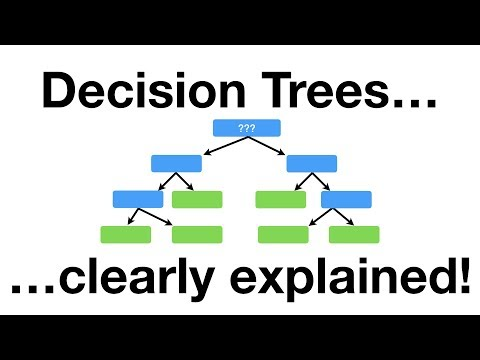

In [219]:
YouTubeVideo("7VeUPuFGJHk")

We will fit a decision tree to the training data, using an ordinal encoder to encode the categorical features:

In [220]:
dt_model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=6, 
                           random_state=42)
)

dt_model.fit(X_train, y_train);

## Prediction

## Probability Estimates

Sometimes a model makes the same prediction for the target of two observations, but is more certain about one prediction. This is the difference between the prediction and the prediction's associated probability. 

The `predict` method predicts the target of an unlabeled observation. The `predict_proba` outputs the probability that an unlabeled observation belongs to one of two classes in the target. Both methods work similarly. They each are run on the fitted model and take a set of features as their input. For example, if we want to see the associated predictions if we used the `X_train` as an input:

In [221]:
dt_model.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

And if we wanted to see the associated probabilities for these predictions:

In [222]:
dt_model.predict_proba(X_train)

array([[0.68323321, 0.31676679],
       [0.68323321, 0.31676679],
       [0.61764706, 0.38235294],
       ...,
       [0.68323321, 0.31676679],
       [0.85714286, 0.14285714],
       [1.        , 0.        ]])

In [223]:
dt_model.predict_proba(X_train).reshape(-1,2)

array([[0.68323321, 0.31676679],
       [0.68323321, 0.31676679],
       [0.61764706, 0.38235294],
       ...,
       [0.68323321, 0.31676679],
       [0.85714286, 0.14285714],
       [1.        , 0.        ]])

Note that there are two probability estimates for each observation, one for the likelihood of each class in the target. The second probability is the likelihood that the unknown observation belongs to the class equal to 1 and the first probability is the likelihood that the unknown observation belongs to the class equal to 0. Whichever class's probability is higher is the predicted class from `predict`. 

<font size="+1">Practice: Generate probability estimates using a trained model in scikit-learn</font>

Try it yourself! Use `predict_proba` to generate probability estimates for the observations in `X_test`. 

In [224]:
# Remove{
dt_model.predict_proba(X_test)
# Remove}

array([[0.33962264, 0.66037736],
       [0.45357143, 0.54642857],
       [0.43532338, 0.56467662],
       ...,
       [0.68323321, 0.31676679],
       [0.75289575, 0.24710425],
       [0.45357143, 0.54642857]])

## Evaluation

### Calculating Accuracy Score

A natural choice for a metric for classification is accuracy. Accuracy is equal to the number of observations you correctly classified over all observations. For example, if your model properly identified 77 out of 100 images, you have an accuracy of 77%. Accuracy is an easy metric to both understand and calculate. Mathematically, it is simply

$$ \frac{\text{number of correct observations}}{\text{number of observations}}.$$

Model accuracy can be calculated using the `accuracy_score` function. The function requires two arguments, the true labels and the predicted labels. For example, if we want to calculate the model accuracy score on the training data:  

In [225]:
acc_train = accuracy_score(y_train, dt_model.predict(X_train))
print("Training Accuracy:", round(acc_train, 2))

Training Accuracy: 0.69


<font size="+1">Practice: Calculate the accuracy score for a model in scikit-learn</font>

Try it yourself! Calculate the model's accuracy on the validation data:

In [226]:
acc_val = accuracy_score(y_val, dt_model.predict(X_val))
print("Validation Accuracy:", round(acc_val, 2))

Validation Accuracy: 0.67


### Baseline Accuracy Score

How do you know whether or not the accuracy score you calculated for your model is good? A baseline accuracy score for the model can be used to compare your model accuracy results against. A common baseline is to use the percentage that the majority class shows up in the training data. This would be your accuracy if you simply predicted the majority class for all observations. If the model is not beating this baseline, that suggests that the features are not adding any valuable information to classify your observations. 

We can use the `value_counts` method with the `normalize = True` argument to calculate the baseline accuracy:

In [227]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.65


### Confusion Matrix

Accuracy score may not provide enough information to assess how a model is performing because it only gives us an overall score. Also, imbalanced data can lead to a high accuracy score even when a model isn't particularly useful. If we want to know what fraction of all positive predictions were correct and what fraction of positive observations did we identify, we can use a **confusion matrix**.

A confusion matrix is a table summarizing the performance of the model by enumerating true and false positives and the true and false negatives.

|                     | Positive Observation     | Negative Observation    |
|---------------------|:------------------------:|:-----------------------:|
| **Positive Prediction** |     True Positive (`TP`)   | False Positive (`FP`)     |
| **Negative Prediction** | False Negative (`FN`)      |     True Negative (`TN`)  |

Refer to this video for more details in confusion matrix:

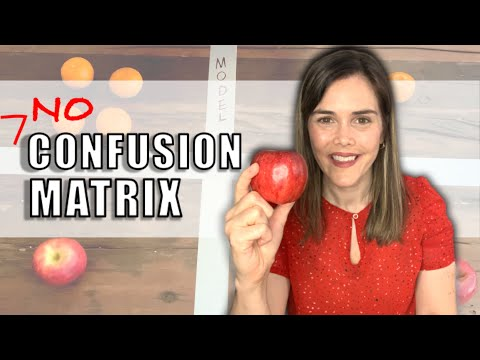

In [228]:
YouTubeVideo("_cpiuMuFj3U")

Here is the code to get the confusion matrix in the training set:

In [229]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, dt_model.predict(X_train))
cm

array([[13151,  1530],
       [ 5577,  2324]])

You can also use the heatmap to better visualize confusion matrix using `ConfusionMatrixDisplay`:

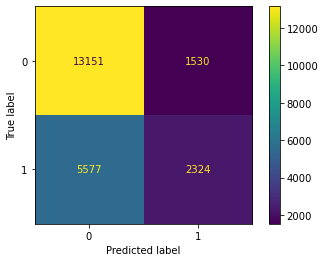

In [230]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()
plt.show()

<font size="+1">Practice</font>

Get confusion matrix for the validation set and display with `ConfusionMatrixDisplay`:

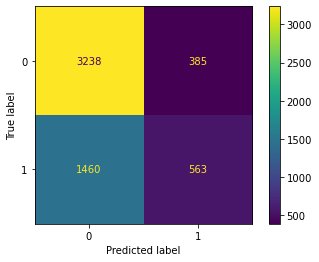

In [231]:
cm = confusion_matrix(y_val, dt_model.predict(X_val))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)

disp.plot()
plt.show()

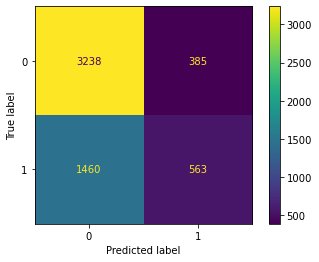

In [247]:
ConfusionMatrixDisplay.from_estimator(dt_model, X_val, y_val);

### Precision Score

Depending on the context of the problem, instead of knowing model performances in both classes, sometimes we are more interested in the results in positive class. That's when we use **precision**. Precision is the fraction of true positives over all positive predictions. It is a measure of how "precise" our model is with regard to labeling observations as positive. 

For example in Project 3, we try to predict whether a company will go bankrupt, with `"bankrupt"` as the positive class. Out of all positive predictions made by the model, some companies actually went bankrupt (True Positive `TP`), while others didn't (False Positive `FP`). Precision measures how many times model predicted positives (`TP`+`FP`) correctly (`TP`). The equation for precision is:

$$ \text{precision} = \frac{\text{TP}}{TP + FP}$$

Using the data and model above, we can get a precision score using the code below:

In [232]:
from sklearn.metrics import precision_score

precision = precision_score(y_train, dt_model.predict(X_train))

print(f"Training Set Precision is {round(precision,2)}")

Training Set Precision is 0.6


<font size="+1">Practice</font>

Get precision for the validation set

In [233]:
precision_val = precision_score(y_val, dt_model.predict(X_val))
print(f"Validation Set Precision is {round(precision_val, 2)}")

Validation Set Precision is 0.59


### Recall Score

What if we care more about the model performance in the negative class? In this case, we need to calculate **recall**. Recall the fraction of true positives over all positive observations. It is a measure of our model's ability to "catch" and properly label observations that are positive. 

Let's return to the Poland bankruptcy example. Of all the companies that actually went bankrupt (`TP`+`FN`), how many companies did out model predict as going bankrupt (`TP`)? That's what recall measures. The equation to calculate recall is:

$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}. $$

Here is the code to calculate recall:

In [234]:
from sklearn.metrics import recall_score

recall = recall_score(y_train, dt_model.predict(X_train))

print(f"Training Set Recall is {round(recall, 2)}")

Training Set Recall is 0.29


<font size="+1">Practice</font>

Get precision for the validation set

In [235]:
recall_val = recall_score(y_val, dt_model.predict(X_val))
print(f"Validation Set Precision is {round(recall_val, 2)}")

Validation Set Precision is 0.28


### Classification Report

We can also use a **classification report** to look at the whole picture of the classification model performances. A classification report includes precision, recall, **F1 score** and **support**. We already know the first two, but F1 score is the harmonic mean of precision and recall, it equation is:

$$ \text{F1} = 2 \left( \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} \right)$$

Support number of observations for each class, thus it is useful to understand whether the data is imbalanced or not.

In [236]:
from sklearn.metrics import classification_report

print(classification_report(y_train, dt_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.70      0.90      0.79     14681
           1       0.60      0.29      0.40      7901

    accuracy                           0.69     22582
   macro avg       0.65      0.59      0.59     22582
weighted avg       0.67      0.69      0.65     22582



Note in the last two rows, we have the macro and the weighted average,. Macro average is the arithmetic average of a metric between the two classes:

$$ \text{0.65} = \frac{0.70+0.60}{2} $$

The weighted average is calculated as:

$$ \frac{\sum(\text{metric of interest} \cdot \text{weight})}{\sum(\text{weights})} $$

Here the weights are the number of observation for each class.

Here you may notice there are two rows of metrics. If you refer back to what we calculated previous on precision and recall, the second row actually align with what we found. That's because we usually define class one as the **positive class**, thus we are referring class 1's metric performance as the true precision and recall value.

<font size="+1">Practice</font>

Get classification report for the validation set

In [237]:

print(classification_report(y_val, dt_model.predict(X_val), target_names=["Not bankrupt", "Bankrupt"]))

              precision    recall  f1-score   support

Not bankrupt       0.69      0.89      0.78      3623
    Bankrupt       0.59      0.28      0.38      2023

    accuracy                           0.67      5646
   macro avg       0.64      0.59      0.58      5646
weighted avg       0.66      0.67      0.64      5646



In [250]:
from teaching_tools.widgets import ConfusionMatrixWidget
c=ConfusionMatrixWidget(dt_model, X_val, y_val)
c.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

## Communication

### Plotting a Decision Tree

The `plot_tree` function can be used to a plot a decision tree. The visualization is fit to the size of the axis set with `matplotlib`. Use the `figsize` argument of `plt.subplots` to control the size of the tree.

We'll demonstrate how to use the `plot_tree` function to graphically display a decision tree:

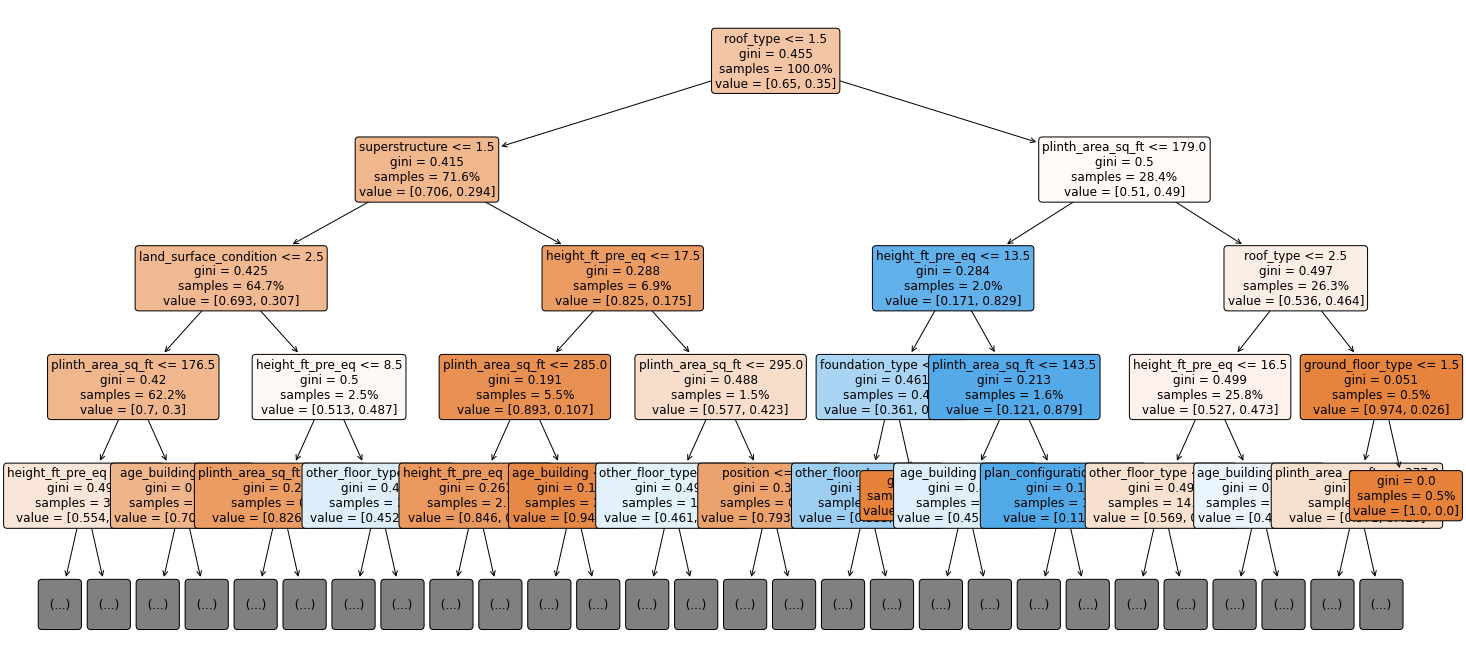

In [238]:
from sklearn import tree
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))

# Plot tree
tree.plot_tree(
    dt_model.named_steps["decisiontreeclassifier"],
    feature_names=dt_model.named_steps["decisiontreeclassifier"].feature_names_in_,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=4,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

<font size="+1">Practice: Plot a decision tree using `scikit-learn`</font>

Try it yourself! Use `plot_tree` to plot the decision tree from the `model` object, modifying the parameters of the tree to only display the first 3 levels and to not display the proportion of classes in a leaf.  

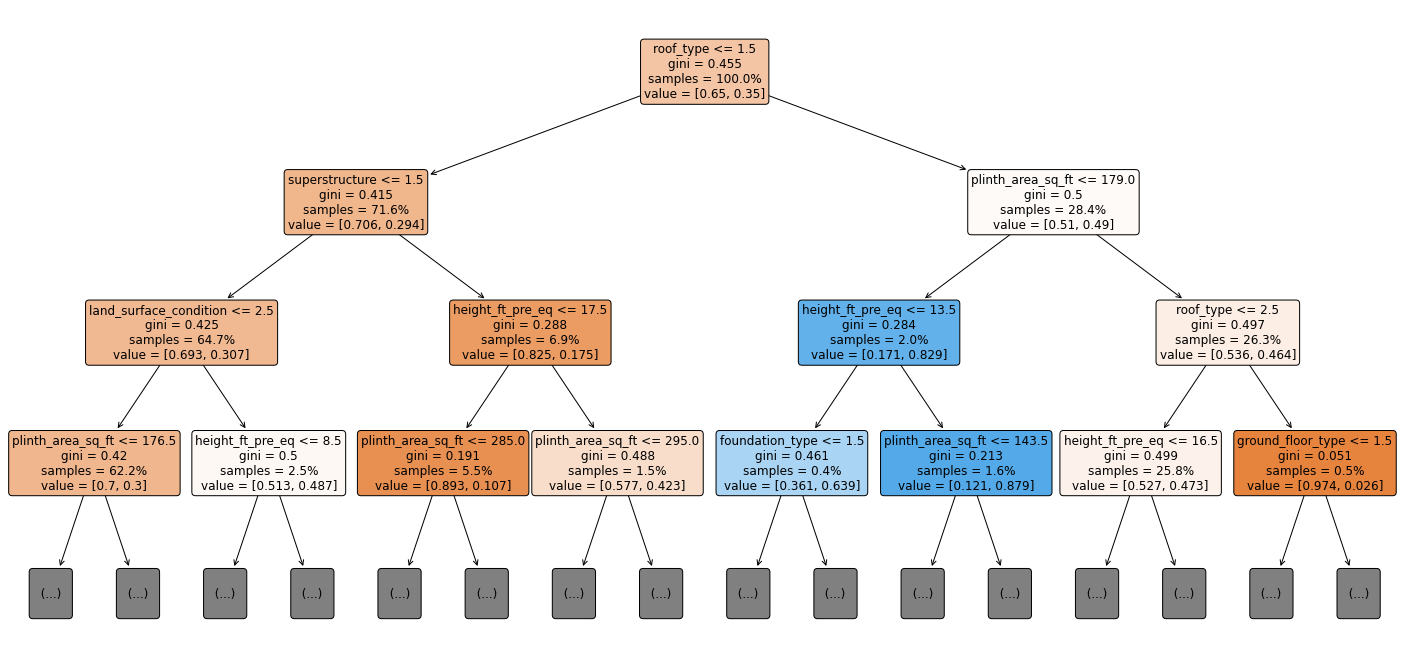

In [239]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))

# Plot tree
tree.plot_tree(
    dt_model.named_steps["decisiontreeclassifier"],
    feature_names=dt_model.named_steps["decisiontreeclassifier"].feature_names_in_,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

The feature names and importance of features can be extracted from the column names in your training set. For the `importances`, you can access the [`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute of your model's `DecisionTreeClassifier`. 

In [240]:
features = X_train.columns
importances = dt_model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.04860263 0.21910723 0.17064119]


The importance of a feature is based on how well the feature correctly classifies observations. In a decision tree, this is on average how much a feature reduces the impurity metric. The tree determines how to split based on an impurity function. The impurity function calculates how homogeneous observations are at a particular leaf node. Conditions that do a better job minimizing impurity are used to split first. The `sklearn.tree` algorithm uses the Gini impurity by default. The Gini impurity measures the probability of an incorrect classification in the model for each branch. It ranges from 0 to 1. 

Let's create a bar chart to plot each feature with its corresponding importance. To build this bar chart, we'll create a pandas Series named feat_imp, where the index is features and the values are your importances. The Series should be sorted from smallest to largest importance so that the bar chart is also in order. 

In [241]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

plan_configuration    0.000953
ground_floor_type     0.002509
position              0.005270
foundation_type       0.006665
other_floor_type      0.039385
dtype: float64

Next, we'll use the series to build a bar chart:

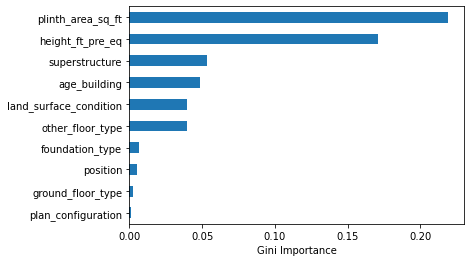

In [242]:
feat_imp.head(10).plot(kind="barh")
plt.xlabel("Gini Importance");

# Classification with Ensemble Models

Ensemble models are machine learning models that use more than one predictor to arrive at a prediction. A group of predictors form an _ensemble_. In general, ensemble models perform better than using a single predictor. There are three types of ensemble models: **bagging**, **boosting**, and **blending**. Of the three, decision trees are commonly used to construct bagging and boosting models.

## Random Forest

The performance of a single decision tree will be limited. Instead of relying on one tree, a better approach is to aggregate the predictions of multiple trees. On average, aggregation will perform better than a single predictor. You can envision the aggregation as mimicking the idea of "wisdom of the crowd." We call a tree based model that aggregates the predictions of multiple trees a **random forest**.

In order for a random forest to be effective, the model needs a diverse collection of trees. There should be variations in the chosen thresholds for splitting and the number of nodes and branches. There is no point in aggregating the predicted results if all the trees are nearly identical and produce the same result. There is no "wisdom of the crowd" if everyone thinks alike. To achieve a diverse set of trees, we need to:

1. Train each tree in the forest using a different subset of the training set.
1. Only consider a subset of features when deciding how to split the nodes.

On the first point, we would ideally generate a new training set for each tree. However, oftentimes it's too difficult or expensive to collect more data, so we have to make do with what we have. Bootstrapping is a general statistical technique to generate "new" data sets with a single set by random sampling with _replacement_. Sampling with replacement allows for a data point to be sampled more than once.

Typically, when training the standard decision tree model, the algorithm will consider all features in deciding the node split. Considering only a subset of your features ensures that your trees do not resemble each other. If the algorithm had considered all features, a dominant feature would be continuously chosen for node splits.

The hyperparameters available for random forests include those of decision tress with some additions.

<table>
<tr>
<th style="text-align: left">Hyperparameter</th>
<th style="text-align: left">Description</th>
</tr>
    
<tr>
<td style="text-align: left"><code>n_estimators</code></td>
<td style="text-align: left">The number of trees in the forest</td>
</tr>

<tr style="text-align: left">
<td style="text-align: left"><code>max_samples</code></td>
<td style="text-align: left">If bootstrap is True, the number of samples to draw from X to train each base estimator</td>
</tr>

<tr style="text-align: left">
<td style="text-align: left"><code>max_features</code></td>
<td style="text-align: left">The number of features to consider when looking for the best split</td>
</tr>

<tr>
<td style="text-align: left"><code>n_jobs</code></td>
<td style="text-align: left">The number of jobs to run in parallel when fitting and predicting</td>
</tr>

<tr style="text-align: left">
<td style="text-align: left"><code>warm_start</code></td>
<td style="text-align: left">If set to <code>True</code>, reuse the trained tree from a prior fitting and just train the additional trees</td>
</tr>
</table>

Since the random forest is based on idea of bootstrapping and aggregating the results, it is referred to as a **bagging** ensemble model.

## Gradient Boosting Trees

Gradient boosting trees is another ensemble model. It uses a collection of tree models arranged in a sequence. Here, the model is built stage-wise; each additional tree aims to correct the previous tree's incorrect. 

Where does the name *gradient* in gradient boosting trees come from? Gradient descent is a minimization algorithm that updates/improves the current answer by taking a step in the direction of minimizing the loss function. This is the same as the gradient boosting trees algorithm as it adds trees to minimize loss/improve model performance. The term **boosting** refers to the algorithm's ability to combine multiple weak models in sequence to form a stronger model. 

Gradient boosting trees have a similar set of hyperparameters as random forests but with some key additions.

<table>
	<tr>
    <th style="text-align: left">Hyperparameter</th>
    <th style="text-align: left">Description</th>
	</tr>  
    <tr>
        <td style="text-align: left"><code>learning_rate</code></td>
        <td style="text-align: left">Multiplicative factor of the tree's contribution to the model.</td>
	</tr>
    <tr>
        <td style="text-align: left"><code>subsample</code></td>
        <td style="text-align: left">Fraction of the training data to use when fitting the trees.</td>
	</tr>
</table>

The learning rate determines how much each tree affect the final outcome and is very important in model convergence. Thus it should be considered during hyperparameter tuning to improve model performance.

# Hyperparameter Tuning

When we defined our decision tree estimator, we chose how many layers the tree would have using the `max_depth` argument. More generally, when we instantiate any estimator, we can pass keyword arguments that will dictate its structure. The decision tree regressor accepts [12 different keyword arguments](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor). These arguments are called **hyperparameters**. This is in contrast to **parameters**, which are the numbers that our model uses to predict labels based on features. Hyperparameters are decided before training and dictate the model's structure. Parameters are optimized during training. Basically all models have hyperparameters. Even a simple linear regressor has a hyperparameter: `fit_intercept`.

Since changing a hyperparameters will change the structure of the model, we should think of choosing hyperparameters as part of the model building process. We can usually use **cross validation** combined with **grid search** when looking for the best model with the right hyperparameters. This process is called **hyperparameter tuning**.

## Cross-Validation

When trying out different hyperparameter settings for estimators (such as the `max_depth` for a random forest), there's a risk in using the test set to evaluate these settings. What happens is that your knowledge about the test set can “leak” into the model, and performance metrics no longer reflect the model's ability to generalize. 

The generalization problem can be solved adding an extra set called **validation set**. In this case, we train the model with the training set, then evaluate different hyperparameters using the validation set. If the model is performing well in both sets, finally we will evaluate the model on the test set.

But there's a drawback to this strategy. The potential issue we may face dividing data into three sets is that we will reduce the number of samples available to fit and train the model. In addition, the model results will change with respect to difference choices of training and validation portions.

The solution here is to use **cross validation** (CV for short). In this case, we will still use a test set, but a validation set is no longer needed. **k-fold CV** is the most used cross validation method(http://scikit-learn.org/stable/modules/cross_validation.html#k-fold). The algorithm divides the training set into $k$ small folds. For each fold $k$, we:

1. Train the model using all the folds but one (i.e. $k-1$ folds) as training data;

1. Validate the model using the remaining fold as if it were test data, and store the performance metric;

This approach makes the best use of all the data we are given, so it's particularly useful when the sample size is small.

Here is the code for conducting a 5-fold cross-validation and reporting the accuracy score for each fold.

In [251]:
from sklearn.model_selection import cross_val_score

clf = make_pipeline(OneHotEncoder(), 
                    DecisionTreeClassifier())
scores = cross_val_score(clf, X_train, 
                         y_train, 
                         cv=5)
scores

array([0.62475094, 0.61478858, 0.63463242, 0.62732507, 0.61713906])

In [253]:
print(
    f"{round(scores.mean(),2)} mean accuracy with a standard deviation of {round(scores.std(),2)}"
)

0.62 mean accuracy with a standard deviation of 0.01


<font size="+1">Practice</font>

Perform 2-fold Cross Validation

In [254]:
clf = make_pipeline(OneHotEncoder(), 
                    DecisionTreeClassifier())
scores = cross_val_score(clf, X_train, 
                         y_train, 
                         cv=2)
scores

array([0.61836861, 0.62811088])

## Grid Search

Another a useful tool for comparing different hyperparameter values is `GridSearchCV`. There are two ideas behind `GridSearchCV`: first we split the data using k-fold cross-validation, and then we train and evaluate models with different hyperparameter settings selected from a grid of possible combinations.

First, we need to define the hyperparameters we want to tune, and tuning in what range. Here we are using an example of searching the best value for the `max_depth` in decision tree model. Since we will be building a pipeline including a transformer and estimator, we need to specify `max_depth` comes from the estimator `decisiontreeclassifier`.

In [255]:
from sklearn.model_selection import GridSearchCV

params = {"decisiontreeclassifier__max_depth": range(1, 15)}

The we define the pipeline and the model with `GridSearchCV`.

In [256]:
clf = make_pipeline(OneHotEncoder(), DecisionTreeClassifier())
model = GridSearchCV(clf, param_grid=params, cv=5)

Lastly fit the model:

In [257]:
model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__max_depth': range(1, 15)})

We can check the best parameters once the fitting process finished:

In [259]:
model.best_params_

{'decisiontreeclassifier__max_depth': 9}

<font size="+1">Practice</font>

Perform `GridSearchCV` on both `max_depth` and `criterion` for the validation set

In [260]:
# Define grid
params = {
    "decisiontreeclassifier__max_depth": range(1,15),
    "decisiontreeclassifier__criterion": ["gini", "entropy", "log_loss"]
}

# Build classifier
clf = make_pipeline(
    OneHotEncoder(),
    DecisionTreeClassifier()
)

# Build grid search model
model = GridSearchCV(clf, param_grid=params, cv=5)

# Fit model to training data
model.fit(X_train, y_train)

# Check the best hyperparameters
model.best_params_

{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 8}

# References & Further Reading

- [`scikit-learn` documentation on decision tree classifier model object](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [`scikit-learn` documentation on decision tree plot](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)
- [`scikit-learn` documentation on decision tree math](https://scikit-learn.org/stable/modules/tree.html)
- [`scikit-learn` confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
- [`scikit-learn` precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
- [`scikit-learn` recall score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [`scikit-learn` classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
-[`Youtube`Confusion Matrix](https://www.youtube.com/watch?v=_cpiuMuFj3U)
- [`scikit-learn`Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html)
- [`scikit-learn`k-fold Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold)

